In [1]:
from scipy.sparse import csr_matrix, load_npz, save_npz, coo_matrix
import numpy as np 
import pandas as pd 
from sklearn.metrics import roc_auc_score,average_precision_score
import matplotlib.pyplot as plt 
from scipy.stats import entropy
from tqdm import tqdm 
import os 
import json 
import types 

import seaborn as sns

In [2]:
from sparsechem import load_results

In [3]:
pvs = ['0'
       ,'0_2'
       ,'0_4'
       ,'0_5'
       ,'0_6'
       ,'0_7'
       #,'0_8'
       #,'0_9'
       #,'0_95'
       #,'0_99'
      ]

In [4]:
datapath = '../aux_data_preperation/baseline_plus_aux_data/'


In [5]:
# labels - filtering on the test fold already here in order to drop data
fold_te = 0 
path = os.path.join(datapath, 'matrices/cls/cls_T11_fold_vector.npy')
folds = np.load(path)

path = os.path.join(datapath, 'matrices/cls/cls_T10_y.npz')
y = load_npz(path)

fte_indx = np.where([folds==fold_te])[1]

y_df = pd.DataFrame({
    'label':coo_matrix(y).data
    ,'row':coo_matrix(y).row
    ,'col':coo_matrix(y).col
}).query('row in @fte_indx')

In [6]:
# get the main tasks that correspond to pseudolabels

path = './files/mapping/baseline_image_model_baselineaux_task_mapping.csv'
df_matching = pd.read_csv(path)

l = list(df_matching['cont_classification_task_id_baseline']) # this is the corresponding main task in the baseline+aux setup
y_true_df = y_df.query('col in @l')


In [7]:
# get the lables for the auxiliary tasks that correspond to the pseudolabels

path = os.path.join(datapath, 'results_tmp/classification/T8c.csv')
t8c = pd.read_csv(path)

# baseline dataset should not contain HTS data : if this is the case, other approach should be taken
l = list(t8c[t8c['assay_type'] == 'AUX_HTS']['cont_classification_task_id'])
y_pseudolabels_df = y_df.query('col in @l')

In [8]:
# col -> pseudolabel col
## strategy : add the cont_classification_task_id via the input_assay_id to the y_pseudolabels_df for merging with the preds

df_pseudolabel_to_maintasks = pd.merge(
    # connect the aux tasks' cont_classification_task_id from the base+aux model 
    t8c[['input_assay_id','cont_classification_task_id']] ## this works because every aux task has an unique input assya id 
    ,df_matching[['cont_classification_task_id_baseline','baseline_compliant_input_assay_id_image', 'input_assay_id_image']]
    ,left_on='input_assay_id' ## this works because every aux task has an unique input assya id 
    ,right_on='baseline_compliant_input_assay_id_image'
    ,how='inner'
    ,suffixes=('_baselineaux','_matching')
)

In [9]:
y_pseudolabels_df_mapped = pd.merge(
    y_pseudolabels_df
    ,df_pseudolabel_to_maintasks
    ,left_on='col'
    ,right_on='cont_classification_task_id'
    ,how='inner'
)

In [10]:
## now start picking up the predictions

In [11]:
# baseline

In [12]:
path = '../aux_data_predictions/preds_baseline/pred_aux_fold0-class.npy'
preds_baseline = np.load(path, allow_pickle=True).item()

preds_baseline_df = pd.DataFrame({
    'pred':coo_matrix(preds_baseline).data
    ,'row':coo_matrix(preds_baseline).row
    ,'col':coo_matrix(preds_baseline).col
})

In [13]:
# matching the labels to the predictions for the baseline
preds_labels_baseline_df = pd.merge(
    preds_baseline_df
    ,y_pseudolabels_df_mapped
    ,left_on=['row','col']
    ,right_on=['row','cont_classification_task_id_baseline']
)

In [14]:
# baseline + aux data 

In [15]:
preds_ppvnpv_df = {}
num=1
for pv in tqdm(pvs) :
    path = f'../aux_data_predictions/ppv_npv_preds/Preds_{str(num).zfill(3)}_ppv{pv}_npv{pv}/preds/pred_aux_fold0-class.npy'
    preds_ppvnpv = np.load(path, allow_pickle=True).item()
    preds_ppvnpv_df[pv] = pd.DataFrame({
        'pred':coo_matrix(preds_ppvnpv).data
        ,'row':coo_matrix(preds_ppvnpv).row
        ,'col':coo_matrix(preds_ppvnpv).col
    })
    num+=1
    

100%|██████████| 6/6 [00:00<00:00, 13.47it/s]


In [16]:
# matching the labels to the predictions for the baseline
preds_labels_ppvnpv_df = {}

for pv in tqdm(pvs) : 
    preds_labels_ppvnpv_df[pv] = pd.merge(
        preds_ppvnpv_df[pv]
        ,y_pseudolabels_df_mapped
        ,left_on=['row','col']
        ,right_on=['row','cont_classification_task_id_baseline']
    )

100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


In [17]:
# metrics calculation

In [18]:
rocs = {}
avgprs = {}
rocs_baseline = {}
avgprs_baseline = {}

cols_to_consider = {}
rocs_baseline = {}
avgprs_baseline = {}

for pv in tqdm(pvs) : 
    
    rocs[pv] = []
    avgprs[pv] = []
    rocs_baseline[pv] = []
    avgprs_baseline[pv] = []

    cols_to_consider[pv] = preds_labels_ppvnpv_df[pv]['col_x'].drop_duplicates()

    for col in cols_to_consider[pv] : 
        # baseline
        arr = preds_labels_baseline_df.query('col_x == @col')
        roc = roc_auc_score(arr['label'],arr['pred'])
        rocs_baseline[pv].append(roc)
        avg_pr = average_precision_score(arr['label'],arr['pred'])
        avgprs_baseline[pv].append(avg_pr)
        
        # with aux data
        arr = preds_labels_ppvnpv_df[pv].query('col_x == @col')
        roc = roc_auc_score(arr['label'],arr['pred'])
        rocs[pv].append(roc)
        avg_pr = average_precision_score(arr['label'],arr['pred'])
        avgprs[pv].append(avg_pr)

100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


In [19]:
os.makedirs('./results', exist_ok=True)

### Requested plots for presentation

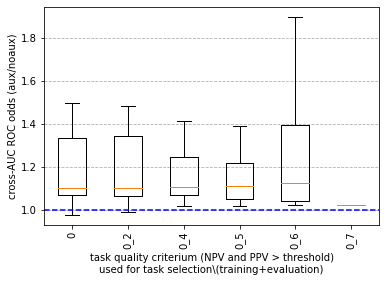

In [20]:
# interprete the roc auc as a probability


l = [
    (np.array(rocs[k])/(1-np.array(rocs[k])))
    / 
    (np.array(rocs_baseline[k])/(1-np.array(rocs_baseline[k])))
     for k in rocs.keys()]

_ = plt.boxplot(l, showfliers=False) 
_ = plt.xticks(list(range(1,len(pvs)+1))
               ,pvs
               , rotation=90
              )
plt.plot( 
    [.5,len(pvs)+.5]
    ,[1,1]
    ,c='blue'
    ,ls='--'
)
plt.ylabel('cross-AUC ROC odds (aux/noaux)')
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection\(training+evaluation)')
plt.grid(ls='--', axis='y')
plt.savefig('./results/odds.png'    
            ,bbox_inches='tight'
            ,pad_inches=0.2
           )

In [21]:
datapath

'../aux_data_preperation/baseline_plus_aux_data/'

In [22]:
agg_tasks = t8c.query('aggregation_weight == 1').query('is_auxiliary == False')['cont_classification_task_id']


sizes = [1200]
p_roc = []
p_pr = []
p_spr = []
prim_perf = {}
prim_perf_baseline = {}

#path = '/projects/home/wheyndri/research/wp1_imageauxdata/15_y3_imageaux_study_taskthreshold/modelling/models/sc_baseline_plus_aux_baseline_noaux_2010_h4000_ldo0.8_wd1e-06_lr0.001_lrsteps10_ep20_fva0_fte-1.json'
path = '../aux_data_training/models_1200/classification_baseline.json'

prim_perf_baseline = load_results(path)

# s-pr calculation : 
df_mgd = pd.merge(
            prim_perf_baseline['validation']['classification'].loc[agg_tasks]['auc_pr']
            ,t8c
            ,how='inner'
            ,left_index=True
            ,right_on='cont_classification_task_id'
        )[['auc_pr','num_total_actives','num_total_inactives']]
df_mgd['pos_rate'] = df_mgd['num_total_actives']/(df_mgd['num_total_actives']+df_mgd['num_total_inactives'])
perf_spr_baseline = np.power(df_mgd['auc_pr']
                     ,(np.log(0.5)/np.log(df_mgd['pos_rate']))
                    )

    
    
num = 1
for pv in pvs : 
    perf_roc = 0 
    perf_pr = 0
    perf_spr = 0
    for size in tqdm(sizes) : 
        #path = '/projects/home/wheyndri/research/wp1_imageauxdata/15_y3_imageaux_study_taskthreshold/modelling/models/sc_baseline_plus_aux_ppv{}_npv{}_2010_h{}_ldo0.8_wd1e-06_lr0.001_lrsteps10_ep20_fva0_fte-1.json'.format(pv,pv,size)
        path = f'../aux_data_training/ppv_npv_scan_{size}/Run_{str(num).zfill(3)}_ppv{pv}_npv{pv}/models/classification_baseline_w_aux.json'

        
        perf_roc = load_results(path)['validation']['classification'].loc[agg_tasks]['roc_auc_score']        
        perf_pr = load_results(path)['validation']['classification'].loc[agg_tasks]['auc_pr']
        
        # s-pr calculation : 
        df_mgd = pd.merge(
            load_results(path)['validation']['classification'].loc[agg_tasks]['auc_pr']
            ,t8c
            ,how='inner'
            ,left_index=True
            ,right_on='cont_classification_task_id'
        )[['auc_pr','num_total_actives','num_total_inactives']]
        df_mgd['pos_rate'] = df_mgd['num_total_actives']/(df_mgd['num_total_actives']+df_mgd['num_total_inactives'])
        perf_spr = np.power(df_mgd['auc_pr']
                     ,(np.log(0.5)/np.log(df_mgd['pos_rate']))
                    )
        
    p_roc.append(np.mean(perf_roc))
    p_pr.append(np.mean(perf_pr))
    p_spr.append(np.mean(perf_spr))
    num +=1
    
p_roc.append(np.mean(prim_perf_baseline['validation']['classification'].loc[agg_tasks]['roc_auc_score']))
p_pr.append(np.mean(prim_perf_baseline['validation']['classification'].loc[agg_tasks]['auc_pr']))
p_spr.append(np.mean(perf_spr_baseline))

100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


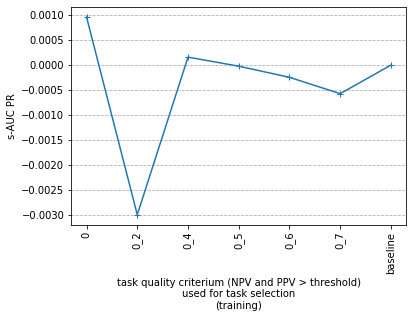

In [23]:
plt.plot(np.array(p_spr)
         -np.array(p_spr[-1])
         , marker='+')
plt.ylabel('s-AUC PR')
_ = plt.xticks(list(range(len(pvs)+1))
               ,pvs+['baseline']
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection\n(training)')
plt.grid(axis='y',ls='--')
plt.savefig('./results/global_s_auc_pr.png'
           ,bbox_inches='tight'
            ,pad_inches=0.2)

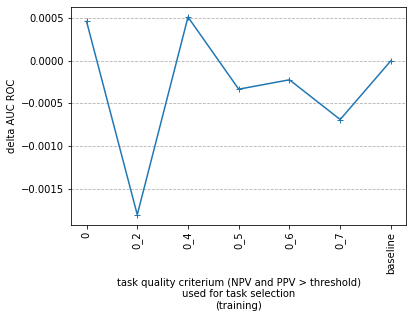

In [24]:
plt.plot(np.array(p_roc)
         -np.array(p_roc[-1])
         , marker='+')
plt.ylabel('delta AUC ROC')
_ = plt.xticks(list(range(len(pvs)+1))
               ,pvs+['baseline']
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection\n(training)')
plt.grid(axis='y',ls='--')
plt.savefig('./results/global_auc_roc.png'
            ,bbox_inches='tight'
            ,pad_inches=0.2)

### Data volumes

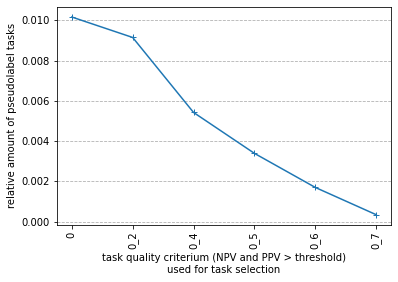

In [25]:
# tasks 
n_non_pseudolabel_tasks = t8c.query('assay_type != "AUX_HTS" and cont_classification_task_id == cont_classification_task_id').shape[0]
plt.plot(
    [len(cols_to_consider[k])/n_non_pseudolabel_tasks for k in rocs.keys()]
    ,marker='+'
)
_ = plt.xticks(list(range(len(pvs)))
               ,pvs
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.ylabel('relative amount of pseudolabel tasks')
plt.grid(ls='--', axis='y')
plt.savefig('./results/relative_tasks.png'
           ,bbox_inches='tight'
            ,pad_inches=0.2)


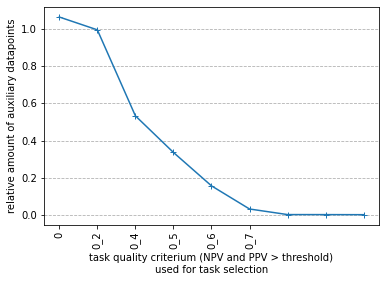

In [26]:
path = '../analysis/cp/summary_eps_0.05_mgd_cp.csv'
df_cp = pd.read_csv(path)

cp_t8 = pd.merge(
    df_cp
    ,t8c
    ,how='inner'
    ,on='input_assay_id'
)

t8c.shape

arr = t8c.query('cont_classification_task_id == cont_classification_task_id')
arr = arr.query('assay_type != "AUX_HTS"')
nonpseudo_count = np.sum(arr['num_total_actives'] + arr['num_total_inactives'])

pvs_num = [0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]


ress = []
for l1 in pvs_num :
    arr = cp_t8.query('validity_0 > @l1').query('validity_1 > @l1')
    res = np.sum(arr['num_total_actives'] + arr['num_total_inactives'])
    ress.append(res)



ress = []
for l1 in pvs_num :
    arr = cp_t8.query('validity_0 > @l1').query('validity_1 > @l1')
    res = np.sum(arr['num_total_actives'] + arr['num_total_inactives'])
    ress.append(res)


plt.plot(ress / nonpseudo_count
         ,marker='+'
)
_ = plt.xticks(list(range(len(pvs)))
               ,pvs
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.ylabel('relative amount of auxiliary datapoints')
plt.grid(ls='--', axis='y')
plt.savefig('./results/relative_datapoints.png'
            ,bbox_inches='tight'
            ,pad_inches=0.2)

In [27]:
pvs

['0', '0_2', '0_4', '0_5', '0_6', '0_7']

### Layer size -- nice to have if you have done the training

In [28]:
sizes = [1200,1800,2400]
l = []

for size in tqdm(sizes) : 
    
    path = f'../aux_data_training/models_{size}/classification_baseline.json'
    prim_perf_baseline = load_results(path)
    prim_perf = {}
    num=1
    for pv in pvs : 
        prim_perf[pv] = []
        path = f'../aux_data_training/ppv_npv_scan_{size}/Run_{str(num).zfill(3)}_ppv{pv}_npv{pv}/models/classification_baseline_w_aux.json'
        prim_perf[pv] = load_results(path)
        tmp = pd.DataFrame(
            prim_perf[pv]['validation']['classification']['roc_auc_score'][cols_to_consider[pv]]
            -prim_perf_baseline['validation']['classification']['roc_auc_score'][cols_to_consider[pv]]
        )
        tmp['pv'] = pv
        tmp['size'] = size
        tmp['relative size'] = size/np.min(sizes)
        l.append(tmp.reset_index())
        num+=1

ccd = pd.concat(l)

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


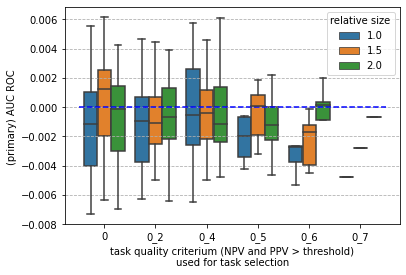

In [29]:
sns.boxplot(hue="relative size", y="roc_auc_score",
            x="pv",showfliers=False,
            data=ccd)  #, palette=["m", "g"]
plt.plot( 
    [-.5,len(pvs)-.5]
    ,[0,0]
    ,c='blue'
    ,ls='--'
)

plt.ylabel('(primary) AUC ROC ')
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.grid(ls='--',axis='y')
plt.savefig('./results/layer_size.png'
            ,bbox_inches='tight'
            ,pad_inches=0.2
           )

### End of requested plots 

### Main plots

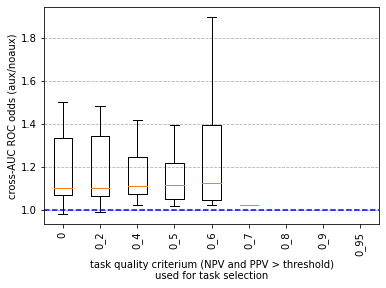

In [47]:
# interprete the roc auc as a probability


l = [
    (np.array(rocs[k])/(1-np.array(rocs[k])))
    / 
    (np.array(rocs_baseline[k])/(1-np.array(rocs_baseline[k])))
     for k in rocs.keys()]

_ = plt.boxplot(l, showfliers=False) 
_ = plt.xticks(list(range(1,len(pvs)+1))
               ,pvs
               , rotation=90
              )
plt.plot( 
    [.5,len(pvs)+.5]
    ,[1,1]
    ,c='blue'
    ,ls='--'
)
plt.ylabel('cross-AUC ROC odds (aux/noaux)')
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.grid(ls='--', axis='y')
plt.savefig('./results/odds.png'    
            ,bbox_inches='tight'
            ,pad_inches=0.2
           )

/home/rama.jabal/.conda/envs/melloddy_tuner_regression/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rama.jabal/.conda/envs/melloddy_tuner_regression/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


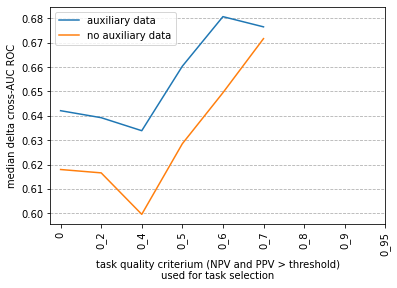

In [48]:
l = [np.median(rocs[k]) for k in rocs.keys()]
lb = [np.median(rocs_baseline[k]) for k in rocs.keys()]
_ = plt.plot(l) 
_ = plt.plot(lb) 
_ = plt.xticks(list(range(len(pvs)))
               ,pvs
               , rotation=90
              )
plt.grid(axis='y', ls='--')
plt.ylabel('median delta cross-AUC ROC')
plt.legend(['auxiliary data', 'no auxiliary data'])
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.savefig('./results/cross_auc_roc.png'    
            ,bbox_inches='tight'
            ,pad_inches=0.2
           )

### Layer size

In [49]:
sizes = [4000,6000,8000]
l = []

for size in tqdm(sizes) : 
    
    path = '../aux_data_training/models/classification_baseline.json'
    prim_perf_baseline = load_results(path)
    prim_perf = {}
    num=1
    for pv in pvs : 
        prim_perf[pv] = []
        path = f'../aux_data_training/ppv_npv_scan/Run_{str(num).zfill(3)}_ppv{pv}_npv{pv}/models/classification_baseline_w_aux.json'
        prim_perf[pv] = load_results(path)
        tmp = pd.DataFrame(
            prim_perf[pv]['validation']['classification']['roc_auc_score'][cols_to_consider[pv]]
            -prim_perf_baseline['validation']['classification']['roc_auc_score'][cols_to_consider[pv]]
        )
        tmp['pv'] = pv
        tmp['size'] = size
        l.append(tmp.reset_index())
        num+=1

ccd = pd.concat(l)

  0%|          | 0/3 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../aux_data_training/models/classification_baseline.json'

In [ ]:
sns.boxplot(hue="size", y="roc_auc_score",
            x="pv",showfliers=False,
            data=ccd)  #, palette=["m", "g"]
plt.plot( 
    [-.5,len(pvs)-.5]
    ,[0,0]
    ,c='blue'
    ,ls='--'
)

plt.ylabel('(primary) AUC ROC ')
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.grid(ls='--',axis='y')
plt.savefig('./results/layer_size.png'
            ,bbox_inches='tight'
            ,pad_inches=0.2
           )

In [ ]:
### Primary performance

In [ ]:
sizes = [4000,6000,8000]
p_roc = []
p_pr = []

    
num=1  
for pv in pvs : 
    perf_roc = 0 
    perf_pr = 0

    for size in tqdm(sizes) : 
        path = f'../aux_data_training/ppv_npv_scan/Run_{str(num).zfill(3)}_ppv{pv}_npv{pv}/models/classification_baseline_w_aux.json'
        
        perf_roc_new = load_results(path)['validation']['classification_agg']['roc_auc_score']
        perf_roc = perf_roc_new if perf_roc<perf_roc_new else perf_roc
        
        perf_pr_new = load_results(path)['validation']['classification_agg']['auc_pr']
        perf_pr = perf_pr_new if perf_pr<perf_pr_new else perf_pr
        
    p_roc.append(perf_roc)
    p_pr.append(perf_pr)
    num+=1
p_roc.append(prim_perf_baseline['validation']['classification_agg']['roc_auc_score'])
p_pr.append(prim_perf_baseline['validation']['classification_agg']['auc_pr'])

In [ ]:
plt.plot(p_roc)
plt.ylabel('AUC ROC')
_ = plt.xticks(list(range(len(pvs)+1))
               ,pvs+['baseline']
               , rotation=90
              )
plt.savefig('./results/global_auc_roc.png')

In [ ]:
plt.plot(p_pr)
plt.ylabel('AUC PR')
_ = plt.xticks(list(range(len(pvs)+1))
               ,pvs+['baseline']
               , rotation=90
              )
plt.savefig('./results/global_auc_pr.png')

### Data volumes 

In [ ]:
plt.plot(
    [len(cols_to_consider[k]) for k in rocs.keys() ]
)
_ = plt.xticks(list(range(len(pvs)))
               ,pvs
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.ylabel('number of tasks')
plt.grid(ls='--', axis='y')

In [ ]:
plt.plot(
    [len(preds_ppvnpv_df[k]) for k in rocs.keys() ]
    
)
_ = plt.xticks(list(range(len(pvs)))
               ,pvs
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.ylabel('number of auxiliary datapoints')
plt.grid(ls='--', axis='y')

In [ ]:

plt.plot(
    np.array([len(preds_labels_ppvnpv_df[k]) for k in rocs.keys() ])
)
_ = plt.xticks(list(range(len(pvs)))
               ,pvs
               , rotation=90
              )
plt.xlabel('task quality criterium (NPV and PPV > threshold)\nused for task selection')
plt.ylabel('number of auxiliary datapoints')
plt.grid(ls='--', axis='y')

### Primary vs secondary

In [ ]:
plt.scatter(
    rocs_baseline['0_6']
    ,rocs['0_6']
    ,alpha=0.2
)
plt.plot( 
    [0.3,1]
    ,[0.3,1.]
)
plt.xlabel('baseline')
plt.ylabel('with aux data')
plt.grid()
plt.title('cross-AUC ROC')

In [ ]:
fig, ax = plt.subplots(len(pvs[:-3]), figsize=(10,55))

for i,pv in tqdm(enumerate(pvs[:-3])) : 

    k = pv
    ax[i].scatter(
        prim_perf[pv]['validation']['classification']['roc_auc_score'][cols_to_consider[k]]
        -prim_perf_baseline['validation']['classification']['roc_auc_score'][cols_to_consider[k]]
        , 
        (np.array(rocs[k])-np.array(rocs_baseline[k]))/np.array(rocs[k])
        ,alpha=.3
    )
    ax[i].grid('--')
    ax[i].set_xlabel('delta primary AUC ROC')
    ax[i].set_ylim([-.05,.25])
    ax[i].set_xlim([-.06,.03])
    ax[i].set_ylabel('relative delta cross-AUC ROC (%)')
    ax[i].set_title('NPV/PPV threshold {}'.format(pv))
    ax[i].plot( 
    [0,0]
    ,[-.05,0.25]
    ,c='red'
    ,ls='--'
)
    ax[i].plot( 
    [-.06,0.03]
    ,[0,0]
    ,c='red'
    ,ls='--'
)